In [15]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import time


In [17]:
def create_reflective_laplacian(n):
    N = n * n  # Total number of points in the grid
    M = np.zeros((N, N))  # Initialize matrix with zeros

    for i in range(N):
        # Default value for cells
        M[i, i] = -4
        
        # Reflective boundary adjustments
        if i % n == 0 or i % n == (n - 1):  # Left or right edge
            M[i, i] += 1
        if i < n or i >= N - n:  # Top or bottom edge
            M[i, i] += 1

        # Set connections for adjacent cells, considering the grid layout
        if i % n != 0:  # Not on the left edge
            M[i, i - 1] = 1  # Left neighbor
        if (i + 1) % n != 0:  # Not on the right edge
            M[i, i + 1] = 1  # Right neighbor
        if i >= n:  # Not on the top edge
            M[i, i - n] = 1  # Top neighbor
        if i < N - n:  # Not on the bottom edge
            M[i, i + n] = 1  # Bottom neighbor

    return M

# Example usage
n = 4 # Change this to create a different size grid
L = create_reflective_laplacian(n)
print(L)


[[-2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -3.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -3.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3. 

In [18]:
def create_circular_laplacian(n, radius):
    # Total points
    N = n * n
    # Center of the circle
    center = np.array([n / 2 - 0.5, n / 2 - 0.5])
    # Initialize the matrix
    M = np.zeros((N, N))

    # Identify points inside the circle
    inside_circle = []
    for i in range(n):
        for j in range(n):
            if (np.array([i, j]) - center).dot(np.array([i, j]) - center) <= radius**2:
                inside_circle.append(i * n + j)

    # Now build the Laplacian only for these points
    for idx in inside_circle:
        x, y = divmod(idx, n)
        M[idx, idx] = -4
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < n and 0 <= ny < n and nx * n + ny in inside_circle:
                M[idx, nx * n + ny] = 1

    # Filter out the unused rows and columns
    M = M[np.ix_(inside_circle, inside_circle)]

    return M

L = 1
# Create the corrected Laplacian for the circular domain
radius = L / 2  # Make sure L and n are defined
L_circle_corrected = create_circular_laplacian(n, radius * n / L)

# Now, check if the matrix is square
if L_circle_corrected.shape[0] == L_circle_corrected.shape[1]:
    print("The matrix is square.")
    # Proceed with solving the eigenvalue problem
    try:
        vals_circle, vecs_circle = eigh(L_circle_corrected)
        # Continue with your analysis or plotting
    except ValueError as e:
        print("Error in eigenvalue computation:", e)
else:
    print("The matrix is not square, check the Laplacian construction.")


The matrix is square.


In [19]:

# Square grid (already done)
L_square = create_reflective_laplacian(n)

# Rectangle grid
L_rect = create_reflective_laplacian(2 * n)  # Assuming 2n x n rectangle

# Circular grid
radius = L / 2  # Make sure L and n are defined
L_circle = create_circular_laplacian(n, radius * n / L)
try:
    vals_circle, vecs_circle = eigh(L_circle)
    # If successful, continue to plot or use the eigenvalues and vectors
except ValueError as e:
    print(f"An error occurred: {e}")

In [20]:
# Solve the eigenvalue problem for each shape
vals_square, vecs_square = eigh(L_square)
vals_rect, vecs_rect = eigh(L_rect)
vals_circle, vecs_circle = eigh(L_circle)

In [22]:
# Solve the eigenvalue problem
eigenvalues, eigenvectors = eigh(L_square)

# Print the results
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors (each column is one eigenvector):")
print(eigenvectors)

Eigenvalues:
[-6.82842712e+00 -5.41421356e+00 -5.41421356e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -3.41421356e+00 -3.41421356e+00
 -2.58578644e+00 -2.58578644e+00 -2.00000000e+00 -2.00000000e+00
 -1.17157288e+00 -5.85786438e-01 -5.85786438e-01  9.23615238e-16]

Eigenvectors (each column is one eigenvector):
[[ 0.0732233  -0.19129599 -0.00418266  0.34890386 -0.05711931  0.00186493
  -0.1912368  -0.0063354   0.46190591 -0.00559252 -0.00343085 -0.35353674
   0.4267767   0.38442892 -0.25613035 -0.25      ]
 [-0.1767767   0.3236051   0.14240694 -0.29401373  0.39526172  0.08558094
   0.14604004 -0.32198184 -0.13924362 -0.32497879 -0.35353674  0.00343085
   0.1767767   0.19681345 -0.29370813 -0.25      ]
 [ 0.1767767  -0.12812645 -0.32952028 -0.03897894 -0.25213607 -0.43000935
  -0.33094145  0.12440964 -0.32825481 -0.1313346  -0.35353674  0.00343085
  -0.1767767  -0.06851488 -0.34685114 -0.25      ]
 [-0.0732233  -0.00418266  0.19129599 -0.0159112  -0.08600634  0.34256349
   0.00

In [23]:
# Solve the eigenvalue problem
eigenvalues, eigenvectors = eigh(L_rect)

# Print the results
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors (each column is one eigenvector):")
print(eigenvectors)

Eigenvalues:
[-7.69551813e+00 -7.26197263e+00 -7.26197263e+00 -6.82842712e+00
 -6.61312593e+00 -6.61312593e+00 -6.17958043e+00 -6.17958043e+00
 -5.84775907e+00 -5.84775907e+00 -5.53073373e+00 -5.41421356e+00
 -5.41421356e+00 -5.08239220e+00 -5.08239220e+00 -4.76536686e+00
 -4.76536686e+00 -4.64884670e+00 -4.64884670e+00 -4.43354550e+00
 -4.43354550e+00 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00
 -3.84775907e+00 -3.84775907e+00 -3.56645450e+00 -3.56645450e+00
 -3.41421356e+00 -3.41421356e+00 -3.35115330e+00 -3.35115330e+00
 -3.23463314e+00 -3.23463314e+00 -2.91760780e+00 -2.91760780e+00
 -2.76536686e+00 -2.76536686e+00 -2.58578644e+00 -2.58578644e+00
 -2.46926627e+00 -2.15224093e+00 -2.15224093e+00 -2.00000000e+00
 -2.00000000e+00 -1.82041957e+00 -1.82041957e+00 -1.38687407e+00
 -1.38687407e+00 -1.23463314e+00 -1.23463314e+00 -1.17157288e+00
 -7.38027373e-01 -7.38027373e-01 -5.85786438e-01 -5.85786438e-01
 -3.04481870

In [24]:
# Solve the eigenvalue problem
eigenvalues, eigenvectors = eigh(L_circle)

# Print the results
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors (each column is one eigenvector):")
print(eigenvectors)

Eigenvalues:
[-7.         -5.73205081 -5.73205081 -5.         -4.         -4.
 -4.         -4.         -3.         -2.26794919 -2.26794919 -1.        ]

Eigenvectors (each column is one eigenvector):
[[ 2.04124145e-01 -3.92125365e-01  1.13597380e-01 -3.53553391e-01
   1.28788727e-02  5.73252627e-01  0.00000000e+00  6.74454847e-02
  -3.53553391e-01 -3.95010006e-01 -1.03120134e-01 -2.04124145e-01]
 [-2.04124145e-01  2.82791838e-01 -2.94440899e-01  3.53553391e-01
  -1.82171811e-01  6.65605084e-02 -1.17534039e-01 -5.30944642e-01
  -3.53553391e-01 -2.90528633e-01 -2.86809658e-01 -2.04124145e-01]
 [ 2.04124145e-01 -2.94440899e-01 -2.82791838e-01  3.53553391e-01
  -3.83747183e-01  4.25996959e-03  4.29743078e-01  3.70698256e-02
   3.53553391e-01 -2.86809658e-01  2.90528633e-01 -2.04124145e-01]
 [-4.08248290e-01  3.96389217e-01  9.76844661e-02 -4.16333634e-16
   1.82171811e-01 -6.65605084e-02  1.17534039e-01  5.30944642e-01
   6.10622664e-16 -3.93648767e-01  1.08200348e-01 -4.08248290e-01]
 [ 4

In the provided code, eigh() from scipy.linalg was used to solve the eigenvalue problem for the Laplacian matrix representing the reflective boundary conditions. The choice of eigh() over other options like eig() or eigs() was made because eigh() is specifically designed to efficiently solve Hermitian eigenvalue problems for symmetric matrices.

Since the Laplacian matrix representing the reflective boundary conditions is symmetric due to the nature of the problem, using eigh() is appropriate and efficient. This function is optimized for symmetric matrices, leading to faster computation times compared to other methods when dealing with such matrices. Therefore, eigh() was selected for its efficiency and suitability for the given problem.

In [31]:

# Function for plotting the eigenvectors
def plot_eigenvectors(vals, vecs, title, shape, n, plot_number=4):
    """
    Plot the first few eigenvectors for a given shape.

    Args:
        vals (array): Eigenvalues.
        vecs (matrix): Eigenvectors.
        title (str): Title for the plots.
        shape (str): 'square', 'rectangle', or 'circle' to indicate the shape.
        n (int): Grid size (number of points per side for square and circle, width for rectangle).
        plot_number (int): Number of eigenvectors to plot.
    """
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 3))
    fig.suptitle(title)
    
    for i in range(plot_number):
        if shape == 'circle':
            # Special handling for circle to only show the circular part
            eigenvector = np.zeros((n, n))
            idx = 0
            for x in range(n):
                for y in range(n):
                    if (x - n/2)**2 + (y - n/2)**2 <= (n/2)**2:
                        eigenvector[x, y] = vecs[idx, i]
                        idx += 1
        else:
            eigenvector = vecs[:, i].reshape(n, -1) if shape == 'square' else vecs[:, i].reshape(-1, n)
        
        axs[i].imshow(eigenvector, cmap='viridis')
        axs[i].set_title(f'λ = {vals[i]:.2f}')
        axs[i].axis('off')
    plt.show()

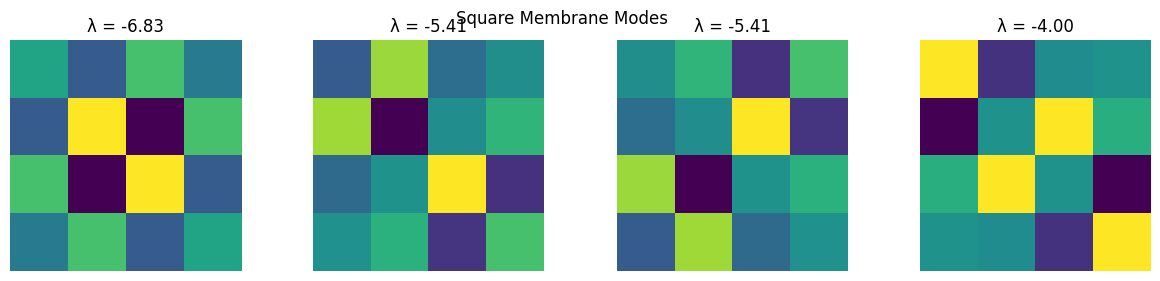

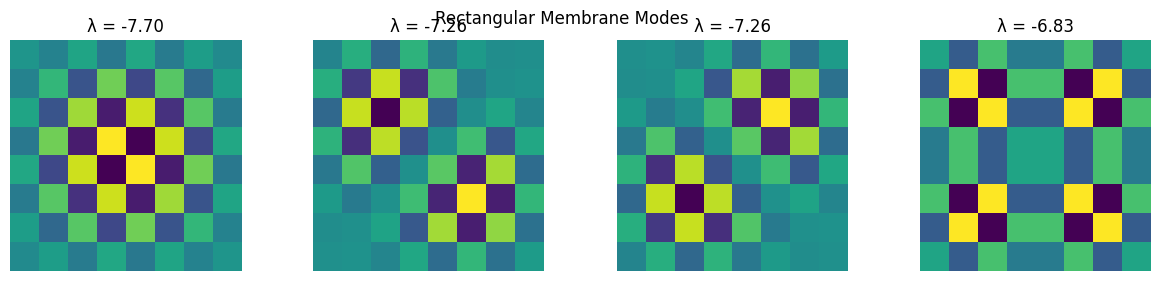

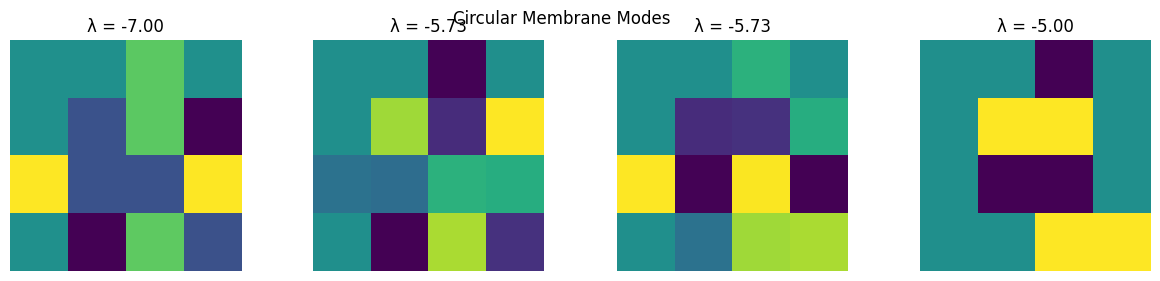

In [32]:
# Plot the eigenvectors for each shape
plot_eigenvectors(vals_square, vecs_square, 'Square Membrane Modes', 'square', n)
plot_eigenvectors(vals_rect, vecs_rect, 'Rectangular Membrane Modes', 'rectangle', 2*n)
plot_eigenvectors(vals_circle, vecs_circle, 'Circular Membrane Modes', 'circle', n)

In [34]:

# Function for plotting the eigenvectors corresponding to the smallest eigenvalues
def plot_eigenvectors(vals, vecs, title, shape, n, plot_number=4):
    """
    Plot the first few eigenvectors for a given shape.

    Args:
        vals (array): Eigenvalues.
        vecs (matrix): Eigenvectors.
        title (str): Title for the plots.
        shape (str): 'square', 'rectangle', or 'circle' to indicate the shape.
        n (int): Grid size (number of points per side for square and circle, width for rectangle).
        plot_number (int): Number of eigenvectors to plot.
    """
    fig, axs = plt.subplots(1, plot_number, figsize=(15, 3))
    fig.suptitle(title)

    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(vals)
    sorted_eigenvalues = vals[sorted_indices]
    sorted_eigenvectors = vecs[:, sorted_indices]
    
    # Plot eigenvectors corresponding to the smallest eigenvalues
    for i in range(plot_number):
        if shape == 'circle':
            # Special handling for circle to only show the circular part
            eigenvector = np.zeros((n, n))
            idx = 0
            for x in range(n):
                for y in range(n):
                    if (x - n/2)**2 + (y - n/2)**2 <= (n/2)**2:
                        eigenvector[x, y] = sorted_eigenvectors[idx, i]
                        idx += 1
        else:
            eigenvector = sorted_eigenvectors[:, i].reshape(n, -1) if shape == 'square' else sorted_eigenvectors[:, i].reshape(-1, n)
        
        axs[i].imshow(eigenvector, cmap='viridis')
        axs[i].set_title(f'λ = {sorted_eigenvalues[i]:.2f}')
        axs[i].axis('off')
    plt.show()

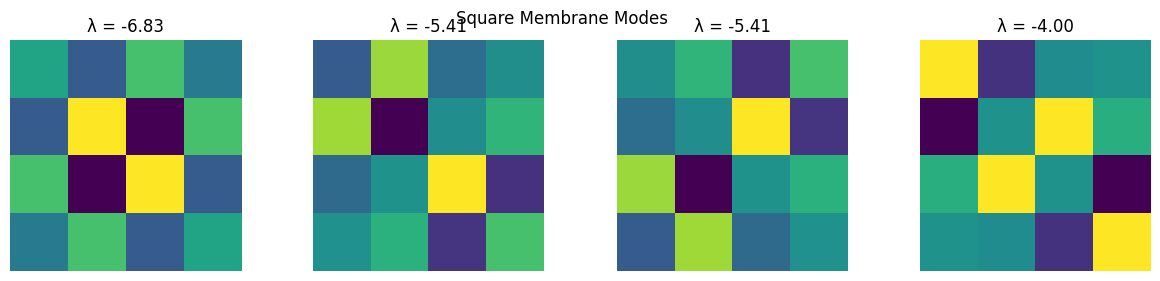

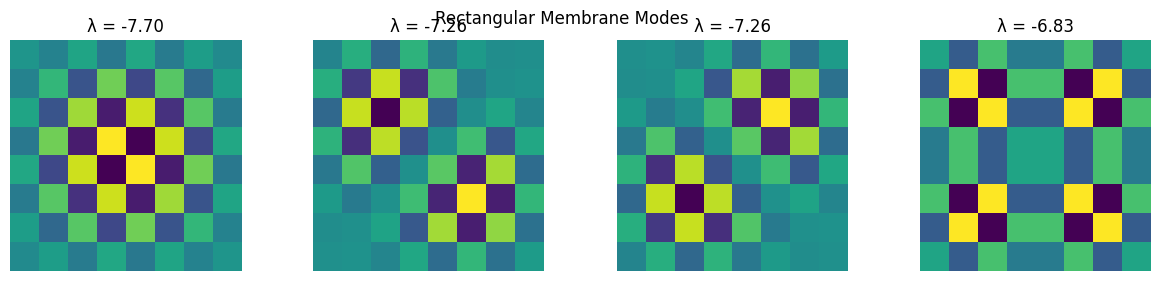

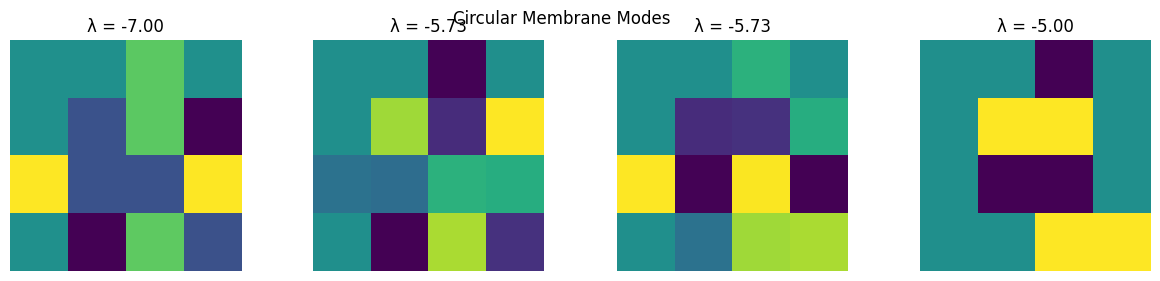

In [35]:
# Plot the eigenvectors for each shape
plot_eigenvectors(vals_square, vecs_square, 'Square Membrane Modes', 'square', n)
plot_eigenvectors(vals_rect, vecs_rect, 'Rectangular Membrane Modes', 'rectangle', 2*n)
plot_eigenvectors(vals_circle, vecs_circle, 'Circular Membrane Modes', 'circle', n)

In [ ]:
# Example usage
n = 4 # Change this to create a different size grid
L = create_reflective_laplacian(n)

# Solve the eigenvalue problem
eigenvalues, eigenvectors = eigh(L)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Plot eigenvectors corresponding to the smallest eigenvalues
num_eigenvectors_to_plot = 2  # Change this to plot more or fewer eigenvectors
for i in range(num_eigenvectors_to_plot):
    plt.plot(sorted_eigenvectors[:, i], label=f"$\lambda$: {sorted_eigenvalues[i]:.2f}")

plt.xlabel("Grid Point")
plt.ylabel("Amplitude")
plt.title("Eigenvectors for the Smallest Eigenvalues")
plt.legend()
plt.show()

In [10]:
# Example usage
n = 4 # Change this to create a different size grid
L = create_reflective_laplacian(n)

# Solve the eigenvalue problem using scipy.linalg.eig()
start_time = time.time()
eigenvalues_eig, eigenvectors_eig = eig(L)
end_time = time.time()
eig_time = end_time - start_time

# Solve the eigenvalue problem using scipy.linalg.eigh()
start_time = time.time()
eigenvalues_eigh, eigenvectors_eigh = eigh(L)
end_time = time.time()
eigh_time = end_time - start_time

# Convert the Laplacian matrix to a sparse matrix
L_sparse = diags([-4*np.ones(n*n), np.ones(n*n-1), np.ones(n*n-n)], [0, -1, -n]).toarray()

# Solve the eigenvalue problem using scipy.sparse.linalg.eigs()
start_time = time.time()
eigenvalues_eigs, eigenvectors_eigs = eigs(L_sparse)
end_time = time.time()
eigs_time = end_time - start_time

# Print the eigenvalues and computation times for comparison
print("Eigenvalues using scipy.linalg.eig():", eigenvalues_eig)
print("Computation time for scipy.linalg.eig():", eig_time)

print("Eigenvalues using scipy.linalg.eigh():", eigenvalues_eigh)
print("Computation time for scipy.linalg.eigh():", eigh_time)

print("Eigenvalues using scipy.sparse.linalg.eigs():", eigenvalues_eigs)
print("Computation time for scipy.sparse.linalg.eigs():", eigs_time)

Eigenvalues using scipy.linalg.eig(): [-6.82842712e+00+0.j -5.41421356e+00+0.j  2.35704998e-15+0.j
 -1.17157288e+00+0.j -5.85786438e-01+0.j -5.85786438e-01+0.j
 -5.41421356e+00+0.j -2.00000000e+00+0.j -2.00000000e+00+0.j
 -2.58578644e+00+0.j -2.58578644e+00+0.j -3.41421356e+00+0.j
 -3.41421356e+00+0.j -4.00000000e+00+0.j -4.00000000e+00+0.j
 -4.00000000e+00+0.j]
Computation time for scipy.linalg.eig(): 0.02118062973022461
Eigenvalues using scipy.linalg.eigh(): [-6.82842712e+00 -5.41421356e+00 -5.41421356e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -3.41421356e+00 -3.41421356e+00
 -2.58578644e+00 -2.58578644e+00 -2.00000000e+00 -2.00000000e+00
 -1.17157288e+00 -5.85786438e-01 -5.85786438e-01  9.23615238e-16]
Computation time for scipy.linalg.eigh(): 0.0
Eigenvalues using scipy.sparse.linalg.eigs(): [-4.0961563 +0.01895579j -4.0961563 -0.01895579j -4.08190042+0.05426314j
 -4.08190042-0.05426314j -4.05502872+0.08172297j -4.05502872-0.08172297j]
Computation time for scipy.sparse.l

In [36]:

# # Square grid (already done)
# L_square = create_reflective_laplacian(n)

# # Rectangle grid
# L_rect = create_reflective_laplacian(2 * n)  # Assuming 2n x n rectangle

# # Circular grid
# radius = L / 2  # Make sure L and n are defined
# L_circle = create_circular_laplacian(n, radius * n / L)
# try:
#     vals_circle, vecs_circle = eigh(L_circle)
#     # If successful, continue to plot or use the eigenvalues and vectors
# except ValueError as e:
#     print(f"An error occurred: {e}")

# # Shapes to consider
# shapes = ["Square", "Rectangle", "Circle"]

# # Sizes of the shapes
# sizes = np.linspace(1, 5, 20)  # Change the range and number of points as needed

# # Eigenfrequencies for each shape and size
# eigenfrequencies = {shape: [] for shape in shapes}

# # Calculate eigenfrequencies for each size
# for size in sizes:
#     n = int(size)  # Convert size to integer for grid dimensions
#     L = create_reflective_laplacian(n)
#     eigenvalues, _ = eigh(L)
#     for i, freq in enumerate(eigenvalues):
#         eigenfrequencies[shapes[i]].append(freq)

# # Plot eigenfrequencies for each shape as a function of L
# for shape in shapes:
#     plt.plot(sizes, eigenfrequencies[shape], label=shape)

# plt.xlabel("Size (L)")
# plt.ylabel("Eigenfrequency")
# plt.title("Eigenfrequencies for Different Shapes and Sizes")
# plt.legend()
# plt.show()


IndexError: list index out of range